In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
import warnings
!pip install ray
import ray
warnings.filterwarnings('ignore')
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **MFCC Extraction**

\begin{align} start_{frame} = \big\lfloor start_{time} \times samplingrate \big\rfloor \end{align}

\begin{align} end_{frame} = \big\lfloor end_{time} \times samplingrate \big\rfloor + 1 \end{align}

mfcc shape 39, x

In [ ]:
def padd_z(y):
    z_rate = 19203 - y.shape[0]
    return np.concatenate([np.zeros((int(z_rate / 2))), y, np.zeros((int(z_rate / 2)))]) if z_rate % 2 == 0 else np.concatenate([np.zeros((int(z_rate / 2) + 1)), y, np.zeros((int(z_rate / 2)))])

def mfcc_lab(path_without_ending, target_list):
    if os.path.isfile(path_without_ending + '.wav') == False or os.path.isfile(path_without_ending + '.txt') == False:
        return
    signal, sr = librosa.load(path_without_ending + '.wav')
    with open(path_without_ending + '.txt') as f:
            for line in f:
                if(line == ''): continue
                gr = ''.join(line).strip().split('\t')

                if len(gr) < 3: continue
                if gr[2] not in ['trai', 'phai', 'len', 'xuong']:   continue


                start_frame = int(float(gr[0]) * sr)
                end_frame = int(float(gr[1]) * sr) + 1
                lab = gr[2]
                # trích chọn đặc trưng trên thang mel với các thông số mặc định sampling rate = 22050, window hann, frame_size = 2048, hop_size = 512 (SFT matrix n_frame x window_length)
                # Dựa vào biến đổi Fast Fourier Transform trên từng frame
                # trích chọn 13 đặc trưng MFCC từ Discrete Cosine Transform với các bộ lọc tam giác nối chân nhau từ spg: ma trận sau khi short time fourier transform trên segment.
                # đặc trưng thứ 13 là trung bình năng lượng của 12 đặc trưng
                mfccs = librosa.feature.mfcc(y=padd_z(signal[start_frame:end_frame]), n_mfcc=13, sr=sr)
                # CMVN
                mfccs = mfccs - np.mean(mfccs, axis=1).reshape((-1, 1))
                # trích chọn 13 đặc trưng tiếp theo chính là đạo hàm của 12 đặc trưng mfccs cộng thêm 1 đặc trưng là trung bình năng lượng của 12 đặc trưng đó
                delta_mfccs = librosa.feature.delta(mfccs, order=1)
                
                # tương tự nhưng là đạo hàm của 12 delta_mfccs và 1 trung bình năng lượng của tầng này
                delta2_mfccs = librosa.feature.delta(mfccs, order=2)
                mfccs_39 = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
                target_list.append([mfccs_39, lab])

In [ ]:
# read data without Silence label
def read_data_from_drive(data_fill):
    path = '/content/drive/My Drive/SpeechData/'
    for fnum in range(1, 11):
        for i in range(1, 101):
            mfcc_lab(path + str(fnum) + '/c' + str(i), data_fill)

In [ ]:
# Segment and label list of list
# element: [ Signal, label]
seg_lab = []
read_data_from_drive(seg_lab)

In [ ]:
len(seg_lab)

4811

# **Dynamic Time Wrapping**

In [ ]:
X, y = np.array([np.reshape(seg_lab[i][0].T, (-1)) for i in range(len(seg_lab))]), np.array([0 if seg_lab[i][1]=='trai' else (1 if seg_lab[i][1] == 'phai' else (2 if seg_lab[i][1] == 'len' else 3)) for i in range(len(seg_lab)) ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [ ]:
!pip install lightgbm
import lightgbm as lgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
LGBM_m = lgb.LGBMClassifier()
LGBM_m.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
print(metrics.classification_report(y_test, LGBM_m.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       331
           1       0.98      0.99      0.98       249
           2       1.00      1.00      1.00       300
           3       1.00      0.99      0.99       323

    accuracy                           0.99      1203
   macro avg       0.99      0.99      0.99      1203
weighted avg       0.99      0.99      0.99      1203



Classification report: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       331
           1       0.98      0.99      0.98       249
           2       1.00      1.00      1.00       300
           3       1.00      0.99      0.99       323

    accuracy                           0.99      1203
   macro avg       0.99      0.99      0.99      1203
weighted avg       0.99      0.99      0.99      1203


Accuracy classification score: 99.25%
Precision classification score: 99.26%


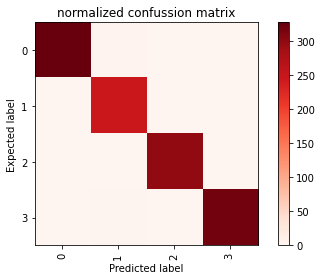

In [ ]:
expected, predicted = y_test, LGBM_m.predict(X_test)
print("Classification report: \n\n%s\n" % (metrics.classification_report(expected, predicted)))
mat = metrics.confusion_matrix(expected, predicted)
# len, xuong, trai, phai
label_names = list(set(expected))
label_names = [x for x in label_names]
plt.figure()
plt.imshow(mat, interpolation='nearest', cmap='Reds')
plt.title('normalized confussion matrix')
plt.colorbar()
plt.ylabel('Expected label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names, rotation=90)
plt.yticks(tick_marks, label_names)
plt.tight_layout()

# accuracy của từng từ đơn
accuracy = metrics.accuracy_score(expected, predicted)
print('Accuracy classification score: {0:.2f}%'.format(100*accuracy))
precision = metrics.precision_score(expected, predicted, average='weighted')
print('Precision classification score: {0:.2f}%'.format(100*precision))

In [ ]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:
NN1 = Sequential()
NN1.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
NN1.add(Dropout(0.3))
NN1.add(Dense(256, activation='relu'))
NN1.add(Dense(256, activation='relu'))
NN1.add(Dropout(0.3))
NN1.add(Dense(128, activation='relu'))
NN1.add(Dense(4, activation='softmax'))
NN1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=10,  #Stop the model training if the validation accuracy doesnt increase in 10 Epochs
                   restore_best_weights=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)
encoder = LabelEncoder()
encoder.fit(y)
# convert integers to dummy variables (i.e. one hot encoded)
dum_y_train = np_utils.to_categorical(encoder.transform(y_train))
dum_y_val = np_utils.to_categorical(encoder.transform(y_val))
dum_y_test = np_utils.to_categorical(encoder.transform(y_test))

In [ ]:
NN_Classifier = NN1.fit(X_train, dum_y_train, \
                          batch_size=32, \
                          epochs=100, \
                          callbacks =[es], \
                          verbose=2, \
                            validation_data=(X_val, dum_y_val))

Epoch 1/100
91/91 - 2s - loss: 4.0155 - accuracy: 0.7030 - val_loss: 0.3822 - val_accuracy: 0.8763 - 2s/epoch - 20ms/step
Epoch 2/100
91/91 - 1s - loss: 0.5306 - accuracy: 0.8749 - val_loss: 0.1518 - val_accuracy: 0.9459 - 975ms/epoch - 11ms/step
Epoch 3/100
91/91 - 1s - loss: 0.3179 - accuracy: 0.9023 - val_loss: 0.1422 - val_accuracy: 0.9459 - 932ms/epoch - 10ms/step
Epoch 4/100
91/91 - 1s - loss: 0.2240 - accuracy: 0.9366 - val_loss: 0.1051 - val_accuracy: 0.9751 - 936ms/epoch - 10ms/step
Epoch 5/100
91/91 - 1s - loss: 0.1744 - accuracy: 0.9473 - val_loss: 0.0894 - val_accuracy: 0.9751 - 909ms/epoch - 10ms/step
Epoch 6/100
91/91 - 1s - loss: 0.1552 - accuracy: 0.9543 - val_loss: 0.0838 - val_accuracy: 0.9802 - 919ms/epoch - 10ms/step
Epoch 7/100
91/91 - 1s - loss: 0.1905 - accuracy: 0.9387 - val_loss: 0.1012 - val_accuracy: 0.9740 - 983ms/epoch - 11ms/step
Epoch 8/100
91/91 - 1s - loss: 0.1275 - accuracy: 0.9608 - val_loss: 0.0749 - val_accuracy: 0.9823 - 923ms/epoch - 10ms/step
Epo

In [ ]:
print('Classification Report: ', metrics.classification_report(y_test,  [np.argmax(x) for x in NN1.predict(X_test)] ))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       265
           1       0.97      0.97      0.97       228
           2       1.00      1.00      1.00       247
           3       1.00      1.00      1.00       223

    accuracy                           0.99       963
   macro avg       0.99      0.99      0.99       963
weighted avg       0.99      0.99      0.99       963



In [ ]:
NN1.save('/content/drive/My Drive/Colab Notebooks/nn_speech')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/nn_speech/assets


In [ ]:
NN2 = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/nn_speech')

In [ ]:
np.argmax((NN1.predict(np.reshape(X_test[38], (1, -1)))[0]))

3

In [ ]:
np.reshape(X_test[38], (1, -1)).shape

(1, 1482)

In [ ]:
print(metrics.classification_report(y_test,  [np.argmax(x) for x in NN2.predict(X_test)] ))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       265
           1       0.97      0.97      0.97       228
           2       1.00      1.00      1.00       247
           3       1.00      1.00      1.00       223

    accuracy                           0.99       963
   macro avg       0.99      0.99      0.99       963
weighted avg       0.99      0.99      0.99       963

